In [ ]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
import tensorflow as tf
from IPython import display


In [ ]:
#setting the training space
(trn_imag, trn_labl), (_, _) = tf.keras.datasets.mnist.load_data()
trn_imag = trn_imag.reshape(trn_imag.shape[0], 28, 28, 1).astype('float32')
trn_imag = (trn_imag - 127.5) / 127.5  # Normalize the images to [-1, 1]
#setting the buffer and batch size
BUFFER_SIZE = 60000
BATCH_SIZE = 256
# Batch and shuffle the data
trn_data = tf.data.Dataset.from_tensor_slices(trn_imag).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
def genG_model():
    modelG = tf.keras.Sequential()
    modelG.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    modelG.add(layers.BatchNormalization())
    modelG.add(layers.LeakyReLU())
    modelG.add(layers.Reshape((7, 7, 256)))
    assert modelG.output_shape == (None, 7, 7, 256)  # Note: None is the batch size
    modelG.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert modelG.output_shape == (None, 7, 7, 128)
    modelG.add(layers.BatchNormalization())
    modelG.add(layers.LeakyReLU())
    # upsample to 14x14
    modelG.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert modelG.output_shape == (None, 14, 14, 64)
    modelG.add(layers.BatchNormalization())
    modelG.add(layers.LeakyReLU())
    # upsample to 28x28
    modelG.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert modelG.output_shape == (None, 28, 28, 1)
    return modelG

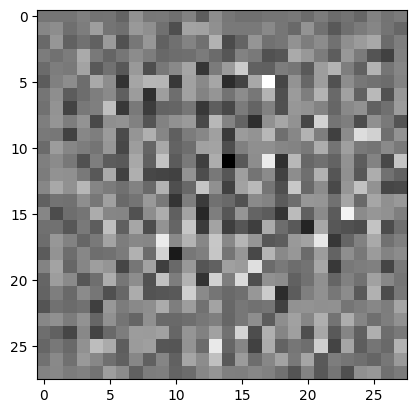

In [ ]:
# sample image generated by the the generator
genG = genG_model()
noise = tf.random.normal([1, 100]) #latent space
generated_image = genG(noise, training=False)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [ ]:
def make_discriminator_model():
    modelD = tf.keras.Sequential()
    modelD.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',input_shape=[28, 28, 1])) #2×2 stride to downsample
    modelD.add(layers.LeakyReLU())
    modelD.add(layers.Dropout(0.3))
    modelD.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')) #downsampling  2×2 stride to downsample
    modelD.add(layers.LeakyReLU())
    modelD.add(layers.Dropout(0.3))
    modelD.add(layers.Flatten())  # classifier real (class=1) or fake (class=0))
    modelD.add(layers.Dense(1, activation='sigmoid'))
    return modelD
    model.add(layers.Flatten())  # classifier real (class=1) or fake (class=0))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

In [ ]:
discriM = make_discriminator_model()
decision = discriM(generated_image)

In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriM_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)
# Setting the discriminator and the generator optimizers,
genG_optimizer = tf.keras.optimizers.Adam(1e-4)
discriM_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(genG_optimizer=genG_optimizer,
                                discriM_optimizer=discriM_optimizer,
                                genG=genG,
                                discriM=discriM)

In [ ]:
#defining the number of epochs to train for
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16
# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
def trn_img(images, genG, discriM, genG_optimizer, discriM_optimizer, noise_dim, BATCH_SIZE):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    # Create separate GradientTape objects for the generator and discriminator
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = genG(noise, training=True)
        real_output = discriM(images, training=True)
        fake_output = discriM(generated_images, training=True)
        gen_loss = generator_loss(fake_output)
        disc_loss = discriM_loss(real_output, fake_output)
    # Compute gradients for generator and discriminator separately
    gradients_of_generator = gen_tape.gradient(gen_loss, genG.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriM.trainable_variables)

    # Apply gradients to update the trainable variables for both models
    genG_optimizer.apply_gradients(zip(gradients_of_generator, genG.trainable_variables))
    discriM_optimizer.apply_gradients(zip(gradients_of_discriminator, discriM.trainable_variables))

In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()
    for image_batch in dataset:
      trn_img(image_batch, genG, discriM, genG_optimizer, discriM_optimizer, noise_dim, BATCH_SIZE)
    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    sv_img(genG,epoch + 1,seed)
    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
  # Generate after the final epoch
  display.clear_output(wait=True)
  sv_img(genG,epochs,seed)

In [ ]:
# Generate and save images :
def sv_img(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)
  fig = plt.figure(figsize=(4, 4))
  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

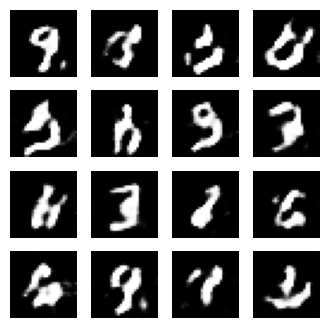

Time for epoch 19 is 1222.573294878006 sec


In [ ]:
train(trn_data, EPOCHS)

In [ ]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))
display_image(EPOCHS)
#create an animated visual which shows changes and training
!pip install git+https://github.com/tensorflow/docs
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)